<a href="https://colab.research.google.com/github/noeljaymon/Emotion-Detection-using-DL/blob/xception/Xception_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard,LearningRateScheduler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

In [ ]:
import h5py
from keras.models import model_from_json
import pickle

In [ ]:
dataset=pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [ ]:
#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
dataset['pixels'] = dataset['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train.shape
shape_x = 48
shape_y = 48

In [ ]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

In [ ]:
X = dataset.iloc[:,1].values
y = dataset.iloc[:,0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [ ]:
#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X = np.reshape(X, (X.shape[0],48,48,1))
y = np.reshape(y, (y.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X = X.astype('float32')

# Scale the data to lie between 0 to 1
X_train /= 255
X_test /= 255
X /= 255

# Change the labels from integer to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y = to_categorical(y)

In [ ]:
local_path ='/content/drive/My Drive/emotion numpy files'
X_train = np.load(local_path + "/X_train.npy")
X_test2 = np.load(local_path + "/X_test2.npy")
y_train = np.load(local_path + "/y_train.npy")
y_test2 = np.load(local_path + "/y_test2.npy")
y_test = np.load(local_path + "/y_test.npy")
X_test = np.load(local_path + "/X_test.npy")

In [ ]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = [0,1,2,3,4,5,6]
nClasses = len(classes)


In [ ]:
def entry_flow(inputs) :
    
    x = Conv2D(32, (3,3), strides = (2,2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3), strides = (2,2),padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
  
    
    previous_block_activation = x
    
    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size,(3,3), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(size, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        
        
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        
        residual = Conv2D(size, (1,1), strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [ ]:

def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        
       
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        
        
        x = keras.layers.Add()([x, previous_block_activation])
        
        previous_block_activation = x
    
    return x

In [ ]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
  #  x=Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x
    

In [ ]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [ ]:
xception = Model(inputs, outputs)

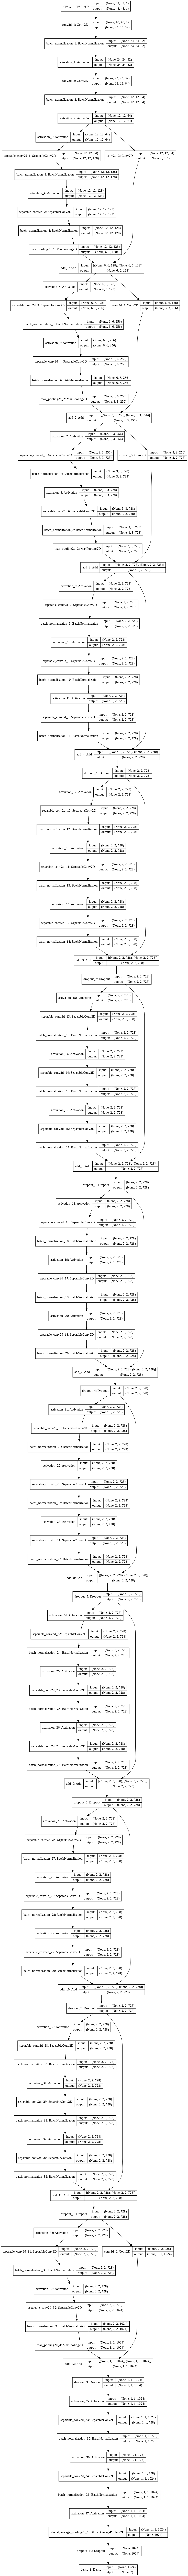

In [ ]:
#plot_model(xception, show_shapes=True, show_layer_names=True)

In [ ]:
xception.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 24, 24, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
import math
epochs = 20
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 12
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
lr_sc = LearningRateScheduler(decay, verbose=1)

In [ ]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128


In [ ]:

datagen = ImageDataGenerator(
        zoom_range=0.1,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),initial_epoch=20, callbacks=[lr_sc],
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, y_test)
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
225/225 [==============================] - 49s 218ms/step - loss: 1.9219 - accuracy: 0.2276 - val_loss: 1.8690 - val_accuracy: 0.2494
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
225/225 [==============================] - 29s 129ms/step - loss: 1.8228 - accuracy: 0.2493 - val_loss: 1.8138 - val_accuracy: 0.2494
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
225/225 [==============================] - 29s 130ms/step - loss: 1.8022 - accuracy: 0.2515 - val_loss: 1.8048 - val_accuracy: 0.2494
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
225/225 [==============================] - 29s 131ms/step - loss: 1.7782 - accuracy: 0.2683 - val_loss: 1.7989 - val_accuracy: 0.2530
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.01.
225/225 [==============================] - 29s 130ms/step - loss: 1.7534 -

In [ ]:

datagen = ImageDataGenerator(
        zoom_range=0.1,          # randomly zoom into images
        rotation_range=20,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),initial_epoch=20, callbacks=[lr_sc],
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = 150, 
    validation_data=(X_test, y_test))

Epoch 21/150

Epoch 00021: LearningRateScheduler setting learning rate to 0.0096.
225/225 [==============================] - 29s 131ms/step - loss: 1.2846 - accuracy: 0.5103 - val_loss: 1.3142 - val_accuracy: 0.4857
Epoch 22/150

Epoch 00022: LearningRateScheduler setting learning rate to 0.0096.
225/225 [==============================] - 29s 129ms/step - loss: 1.2774 - accuracy: 0.5121 - val_loss: 1.3029 - val_accuracy: 0.5040
Epoch 23/150

Epoch 00023: LearningRateScheduler setting learning rate to 0.0096.
225/225 [==============================] - 29s 129ms/step - loss: 1.2690 - accuracy: 0.5177 - val_loss: 1.4602 - val_accuracy: 0.4344
Epoch 24/150

Epoch 00024: LearningRateScheduler setting learning rate to 0.009216.
225/225 [==============================] - 29s 129ms/step - loss: 1.2557 - accuracy: 0.5145 - val_loss: 1.2205 - val_accuracy: 0.5294
Epoch 25/150

Epoch 00025: LearningRateScheduler setting learning rate to 0.009216.
225/225 [==============================] - 29s 129

Text(0.5, 1.0, 'Accuracy Curves')

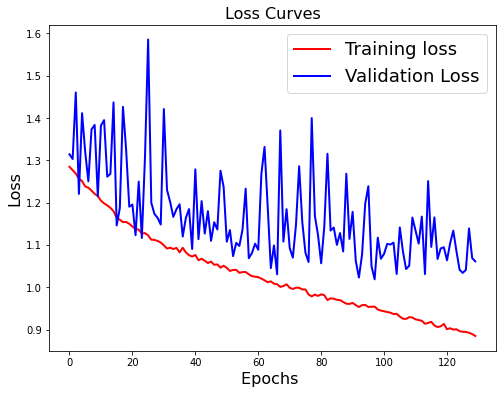

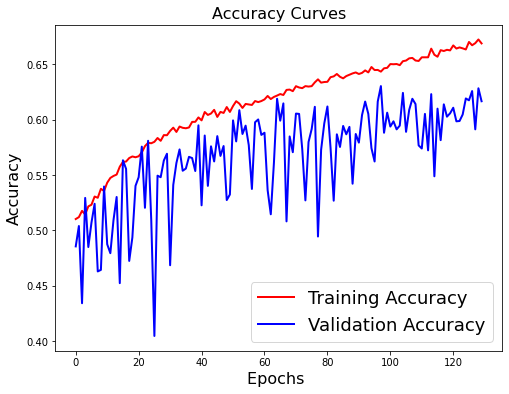

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
score = xception.evaluate(X_test2, y_test2, batch_size=batch_size)
print(score)

3589/3589 [==============================] - 1s 170us/step
[1.0412022704183308, 0.6258010864257812]


In [ ]:
#save the model weights
xception.save('xceptiondecay.h5')
#json_string = Model.to_json()
Model.save_weights( 'savedmodels/model_xception.h5')
#open( 'savedmodels/model_xception.json', 'w').write(json_string)
#Model.save_weights('savedmodels/Emotion_Face_Detection_Model.h5')

TypeError: ignored

In [ ]:
xception.save('xceptiondecay.h5')

In [ ]:
 fer_json = xception.to_json()
with open("xceptionw.json", "w") as json_file:
    json_file.write(fer_json)
xception.save_weights("xceptionw.h5")